## 2.Importing the dataset

In [1]:
!wget https://archive.ics.uci.edu/static/public/773/defungi.zip

--2024-12-12 15:10:39--  https://archive.ics.uci.edu/static/public/773/defungi.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘defungi.zip’

defungi.zip             [   <=>              ] 149.10M  11.8MB/s    in 18s     

2024-12-12 15:10:58 (8.41 MB/s) - ‘defungi.zip’ saved [156341364]



In [3]:
from torchvision import datasets, transforms

# Define transformations (you can modify these as needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224 (common for pretrained models)
    transforms.ToTensor(),          # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet standards
])

# Create the dataset
DATA_DIR = '/content/data'

dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)

# Check class-to-index mapping
print("Class to Index Mapping:", dataset.class_to_idx)

# Check the length of the dataset and an example data point
print("Dataset size:", len(dataset))


Class to Index Mapping: {'H1': 0, 'H2': 1, 'H3': 2, 'H5': 3, 'H6': 4}
Dataset size: 9114


In [4]:
dataset[0]

(tensor([[[0.2624, 0.3138, 0.3309,  ..., 0.3481, 0.3138, 0.2282],
          [0.2624, 0.2967, 0.3481,  ..., 0.2111, 0.1939, 0.1083],
          [0.2624, 0.2796, 0.3481,  ..., 0.0912, 0.0741, 0.0227],
          ...,
          [0.4679, 0.4508, 0.3994,  ..., 0.2111, 0.2111, 0.1939],
          [0.4166, 0.3823, 0.3481,  ..., 0.2111, 0.2282, 0.2111],
          [0.3652, 0.3309, 0.3138,  ..., 0.2111, 0.2282, 0.2111]],
 
         [[0.4503, 0.5028, 0.5028,  ..., 0.5378, 0.5203, 0.4328],
          [0.4503, 0.4853, 0.5203,  ..., 0.4153, 0.3803, 0.2752],
          [0.4503, 0.4678, 0.5378,  ..., 0.2752, 0.2052, 0.1352],
          ...,
          [0.5378, 0.5203, 0.4678,  ..., 0.3452, 0.3452, 0.3452],
          [0.5203, 0.4853, 0.4503,  ..., 0.3452, 0.3803, 0.3803],
          [0.4678, 0.4328, 0.3978,  ..., 0.3452, 0.3803, 0.3803]],
 
         [[0.5136, 0.5659, 0.6182,  ..., 0.4439, 0.4788, 0.4091],
          [0.5485, 0.5834, 0.6356,  ..., 0.3916, 0.4091, 0.3393],
          [0.5834, 0.6182, 0.6879,  ...,

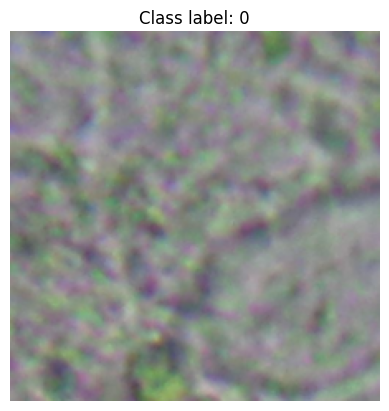

In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Extract a sample image and its label from the dataset
image, label = dataset[0]

def plot_image(image, label):
  # Reverse the normalization to display the image correctly
  unnormalize = transforms.Normalize(
      mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
      std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
  )

  image = unnormalize(image)

  # Convert the image tensor to a NumPy array and transpose it for plotting
  image = image.permute(1, 2, 0).numpy()

  # Plot the image using matplotlib
  plt.imshow(image)
  plt.title(f'Class label: {label}')
  plt.axis('off')  # Hide the axes
  plt.show()

plot_image(image, label)

## 3. Splitting the dataset

In [7]:
from torch.utils.data import random_split, DataLoader

# Calculate sizes for each split
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for each subset
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## 4. Basic CNN model

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Define the CNN architecture
class BasicCNN(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 54 * 54, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## 6. Reasons for choice of activation functions
ReLU (Rectified Linear Unit) is widely used as an activation function in neural networks because it is simple, computationally efficient, and helps address the vanishing gradient problem. It introduces non-linearity by outputting the input directly if it is positive and zero otherwise, allowing the model to learn complex patterns. ReLU is faster to compute compared to other activation functions like sigmoid or tanh and avoids saturating gradients, enabling faster training and better performance for deep networks.

## 7. Training the model

In [25]:
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.001
num_epochs = 20
dropout_rate = 0.4

# Initialize the model, loss function, and optimizer
model = BasicCNN(num_classes=5, dropout_rate=dropout_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average training loss for this epoch
    train_losses.append(running_loss / len(train_loader))

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Average validation loss for this epoch
    val_losses.append(val_loss / len(val_loader))

    # Print epoch stats
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Val Accuracy: {correct/total:.4f}")

Epoch 1/20, Train Loss: 1.1570, Val Loss: 0.9727, Val Accuracy: 0.6180
Epoch 2/20, Train Loss: 0.9762, Val Loss: 0.9504, Val Accuracy: 0.6153
Epoch 3/20, Train Loss: 0.9111, Val Loss: 0.9194, Val Accuracy: 0.6361
Epoch 4/20, Train Loss: 0.8685, Val Loss: 0.9364, Val Accuracy: 0.6400
Epoch 5/20, Train Loss: 0.8200, Val Loss: 0.8974, Val Accuracy: 0.6240
Epoch 6/20, Train Loss: 0.7553, Val Loss: 0.8706, Val Accuracy: 0.6405
Epoch 7/20, Train Loss: 0.6760, Val Loss: 0.9785, Val Accuracy: 0.6350
Epoch 8/20, Train Loss: 0.5976, Val Loss: 1.0362, Val Accuracy: 0.6443
Epoch 9/20, Train Loss: 0.5163, Val Loss: 1.0988, Val Accuracy: 0.6471
Epoch 10/20, Train Loss: 0.4235, Val Loss: 1.1681, Val Accuracy: 0.6372
Epoch 11/20, Train Loss: 0.3512, Val Loss: 1.2955, Val Accuracy: 0.6350
Epoch 12/20, Train Loss: 0.3115, Val Loss: 1.4465, Val Accuracy: 0.6251
Epoch 13/20, Train Loss: 0.2679, Val Loss: 1.4914, Val Accuracy: 0.6284
Epoch 14/20, Train Loss: 0.2726, Val Loss: 1.6875, Val Accuracy: 0.6383
E

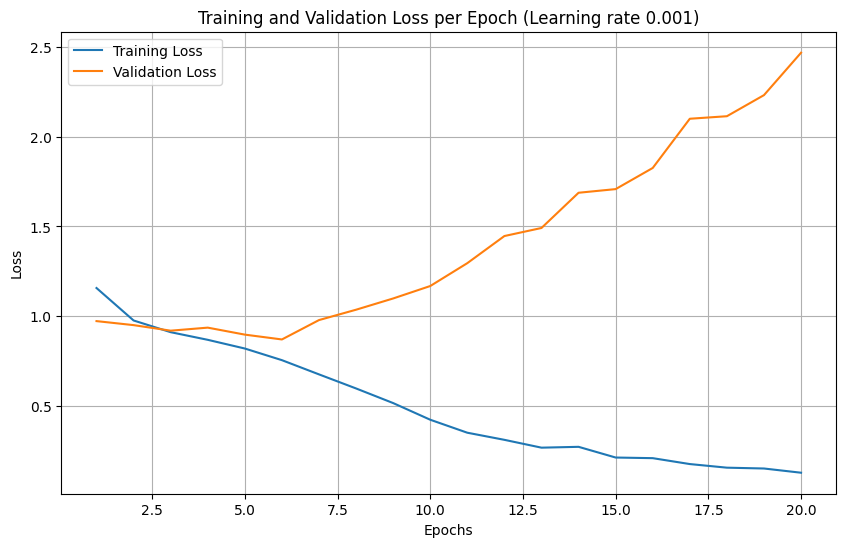

In [26]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch (Learning rate 0.001)")
plt.legend()
plt.grid(True)
plt.show()

There is a clearly visible overfitting happening. For this reason we would have to increase thre dropout rate in thr next training session.

## 8. Reason for choosing Adam over SGD

Adam is often considered better than SGD because it combines the benefits of momentum and adaptive learning rates, enabling faster and more stable convergence. It adjusts learning rates for each parameter dynamically based on the gradient’s mean and variance, making it particularly effective for problems with sparse gradients or varying sensitivities across parameters. While SGD is simpler and can generalize better in some cases, Adam generally requires less hyperparameter tuning and performs well.

In [27]:
# Testing
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {correct/total:.4f}")

Test Loss: 2.5475, Test Accuracy: 0.6343


## 10. Evaluating the model

Test Loss: 2.5475, Test Accuracy: 0.6343


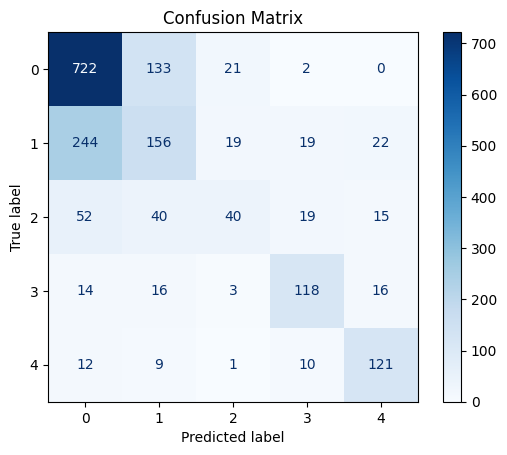

Precision: 0.6100, Recall: 0.6343


In [28]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

# Evaluate the model
model.eval()
test_loss = 0.0
correct = 0
total = 0

# Collect true and predicted labels
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect predictions and labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate test metrics
test_accuracy = correct / total
print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Precision and Recall
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

Predictions are more centered around 0 class label due to overfitting and class imbalance.

## 11. Training for different Learning rates

### LR = 0.0001 (Also increase dropout rate to 0.6)

In [29]:
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.0001
num_epochs = 20
dropout_rate = 0.6

# Initialize the model, loss function, and optimizer
model = BasicCNN(num_classes=5, dropout_rate=dropout_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average training loss for this epoch
    train_losses.append(running_loss / len(train_loader))

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Average validation loss for this epoch
    val_losses.append(val_loss / len(val_loader))

    # Print epoch stats
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Val Accuracy: {correct/total:.4f}")

Epoch 1/20, Train Loss: 1.1162, Val Loss: 0.9402, Val Accuracy: 0.6125
Epoch 2/20, Train Loss: 0.9597, Val Loss: 0.8831, Val Accuracy: 0.6443
Epoch 3/20, Train Loss: 0.9080, Val Loss: 0.8626, Val Accuracy: 0.6471
Epoch 4/20, Train Loss: 0.8500, Val Loss: 0.8452, Val Accuracy: 0.6515
Epoch 5/20, Train Loss: 0.8101, Val Loss: 0.8268, Val Accuracy: 0.6712
Epoch 6/20, Train Loss: 0.7713, Val Loss: 0.7895, Val Accuracy: 0.6740
Epoch 7/20, Train Loss: 0.7113, Val Loss: 0.8085, Val Accuracy: 0.6679
Epoch 8/20, Train Loss: 0.6794, Val Loss: 0.8074, Val Accuracy: 0.6663
Epoch 9/20, Train Loss: 0.6333, Val Loss: 0.7934, Val Accuracy: 0.6690
Epoch 10/20, Train Loss: 0.6031, Val Loss: 0.7888, Val Accuracy: 0.6751
Epoch 11/20, Train Loss: 0.5757, Val Loss: 0.8065, Val Accuracy: 0.6548
Epoch 12/20, Train Loss: 0.5309, Val Loss: 0.8305, Val Accuracy: 0.6636
Epoch 13/20, Train Loss: 0.4940, Val Loss: 0.8274, Val Accuracy: 0.6729
Epoch 14/20, Train Loss: 0.4562, Val Loss: 0.8465, Val Accuracy: 0.6696
E

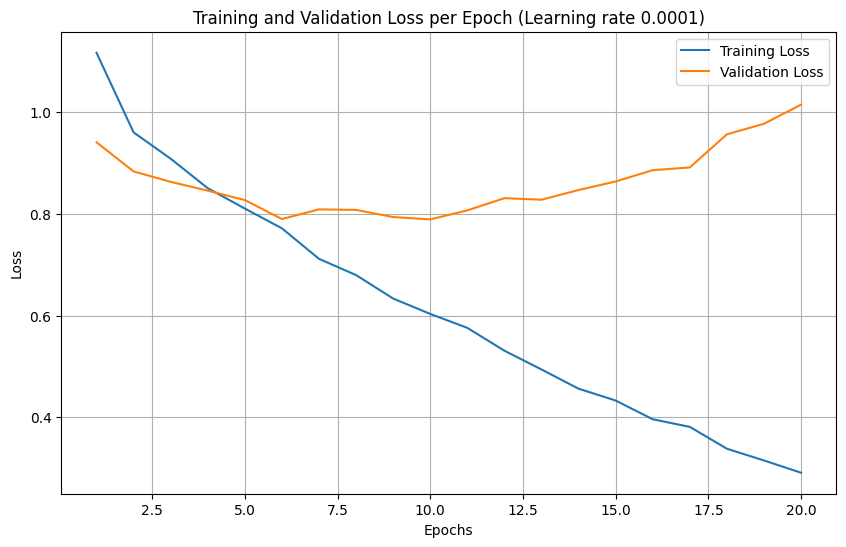

In [30]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch (Learning rate 0.0001)")
plt.legend()
plt.grid(True)
plt.show()

Overfitting is still persistent

### Learning rate = 0.01 and drop out rate = 0.6

In [32]:
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.01
num_epochs = 20
dropout_rate = 0.6

# Initialize the model, loss function, and optimizer
model = BasicCNN(num_classes=5, dropout_rate=dropout_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average training loss for this epoch
    train_losses.append(running_loss / len(train_loader))

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Average validation loss for this epoch
    val_losses.append(val_loss / len(val_loader))

    # Print epoch stats
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Val Accuracy: {correct/total:.4f}")

Epoch 1/20, Train Loss: 18.6525, Val Loss: 1.3382, Val Accuracy: 0.4830
Epoch 2/20, Train Loss: 1.3442, Val Loss: 1.3417, Val Accuracy: 0.4830
Epoch 3/20, Train Loss: 1.3445, Val Loss: 1.3405, Val Accuracy: 0.4830
Epoch 4/20, Train Loss: 1.3410, Val Loss: 1.3391, Val Accuracy: 0.4830
Epoch 5/20, Train Loss: 1.3373, Val Loss: 1.3373, Val Accuracy: 0.4830
Epoch 6/20, Train Loss: 1.3383, Val Loss: 1.3383, Val Accuracy: 0.4830
Epoch 7/20, Train Loss: 1.3363, Val Loss: 1.3393, Val Accuracy: 0.4830
Epoch 8/20, Train Loss: 1.3358, Val Loss: 1.3380, Val Accuracy: 0.4830
Epoch 9/20, Train Loss: 1.3366, Val Loss: 1.3372, Val Accuracy: 0.4830
Epoch 10/20, Train Loss: 1.3347, Val Loss: 1.3387, Val Accuracy: 0.4830
Epoch 11/20, Train Loss: 1.3352, Val Loss: 1.3383, Val Accuracy: 0.4830
Epoch 12/20, Train Loss: 1.3349, Val Loss: 1.3385, Val Accuracy: 0.4830
Epoch 13/20, Train Loss: 1.3338, Val Loss: 1.3372, Val Accuracy: 0.4830
Epoch 14/20, Train Loss: 1.3366, Val Loss: 1.3377, Val Accuracy: 0.4830


### Loss curve for learning rate = 0.01

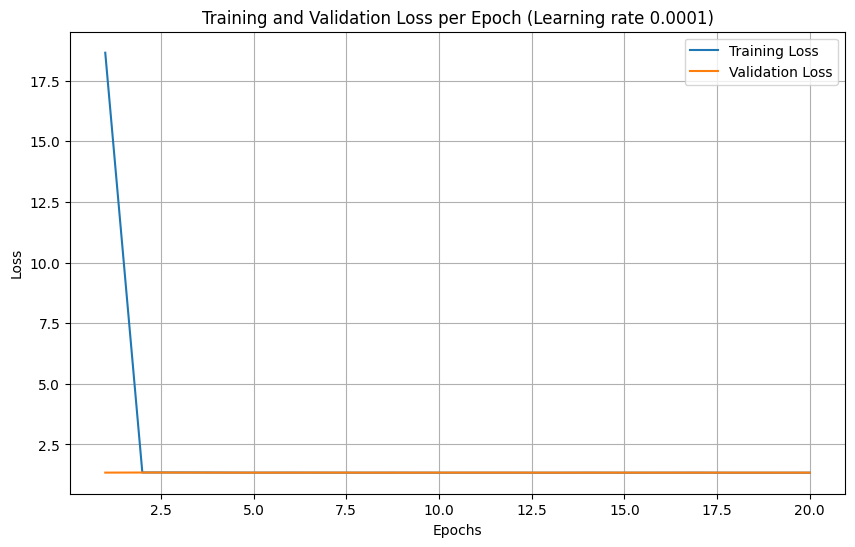

In [33]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch (Learning rate 0.0001)")
plt.legend()
plt.grid(True)
plt.show()

### Learning rate = 0.1

In [35]:
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.1
num_epochs = 20
dropout_rate = 0.6

# Initialize the model, loss function, and optimizer
model = BasicCNN(num_classes=5, dropout_rate=dropout_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average training loss for this epoch
    train_losses.append(running_loss / len(train_loader))

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Average validation loss for this epoch
    val_losses.append(val_loss / len(val_loader))

    # Print epoch stats
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Val Accuracy: {correct/total:.4f}")

Epoch 1/20, Train Loss: 19114.2126, Val Loss: 1.3385, Val Accuracy: 0.4830
Epoch 2/20, Train Loss: 1.3362, Val Loss: 1.3398, Val Accuracy: 0.4830
Epoch 3/20, Train Loss: 1.3376, Val Loss: 1.3436, Val Accuracy: 0.4830
Epoch 4/20, Train Loss: 1.3383, Val Loss: 1.3390, Val Accuracy: 0.4830
Epoch 5/20, Train Loss: 1.3393, Val Loss: 1.3374, Val Accuracy: 0.4830
Epoch 6/20, Train Loss: 1.3380, Val Loss: 1.3393, Val Accuracy: 0.4830
Epoch 7/20, Train Loss: 1.3393, Val Loss: 1.3401, Val Accuracy: 0.4830
Epoch 8/20, Train Loss: 1.3385, Val Loss: 1.3391, Val Accuracy: 0.4830
Epoch 9/20, Train Loss: 1.3393, Val Loss: 1.3406, Val Accuracy: 0.4830
Epoch 10/20, Train Loss: 1.3374, Val Loss: 1.3371, Val Accuracy: 0.4830
Epoch 11/20, Train Loss: 1.3374, Val Loss: 1.3410, Val Accuracy: 0.4830
Epoch 12/20, Train Loss: 1.3393, Val Loss: 1.3408, Val Accuracy: 0.4830
Epoch 13/20, Train Loss: 1.3400, Val Loss: 1.3397, Val Accuracy: 0.4830
Epoch 14/20, Train Loss: 1.3385, Val Loss: 1.3389, Val Accuracy: 0.48

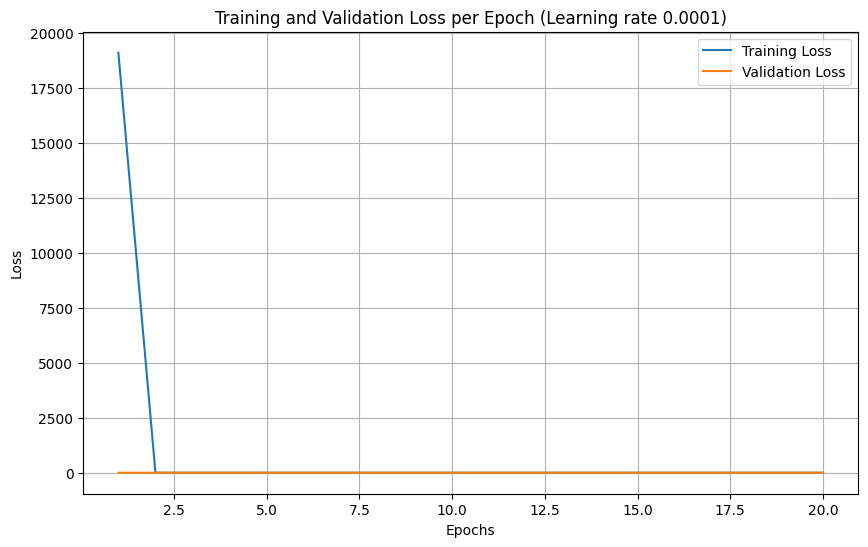

In [36]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch (Learning rate 0.0001)")
plt.legend()
plt.grid(True)
plt.show()

By considering all the learning rates used, selecting 0.001 as the learning rate gives faster convergence. The overfitting was minimized by selecting dropout rate as 0.6. This may be due to the class imbalance in the dataset.